Time-Series Prediction
Time series and sequence prediction could be a really amazing to predict/estimate a robot's trajectory which requires temporal data at hand. In this assignemnt we will see how this could be done using Deep Learning.

Given a dataset [link](https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv) for airline passengers prediction problem. Predict the number of international airline passengers in units of 1,000 given a year and a month.
Here is how the data looks like.

In [2]:
import netron 
netron.start('rnnmodel.onnx')

Serving 'rnnmodel.onnx' at http://localhost:8080


('localhost', 8080)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
file_name = 'experimental/Training.csv' # dataset path
# Reading data using pandas or csv
df = pd.read_csv(file_name)
print(df.columns)

Index(['Time', 'Output Speed', 'Input Torque', 'Input Speed', 'Weight on bit'], dtype='object')


In [3]:
df

,Time,Output Speed,Input Torque,Input Speed,Weight on bit
0,0.000,148.157782,0.546254,104.776226,539.866525
1,0.001,148.870922,0.566799,105.120533,537.944529
2,0.002,149.556036,0.594301,106.241970,536.005967
3,0.003,150.212917,0.628518,108.393450,534.037938
4,0.004,150.841484,0.669332,109.377789,532.056127
...,...,...,...,...,...
52995,52.995,141.525790,1.402770,102.036217,448.634747
52996,52.996,142.137385,1.391925,101.221814,447.199109
52997,52.997,142.726691,1.381913,100.893232,445.788984
52998,52.998,143.293376,1.372741,101.865686,444.418114


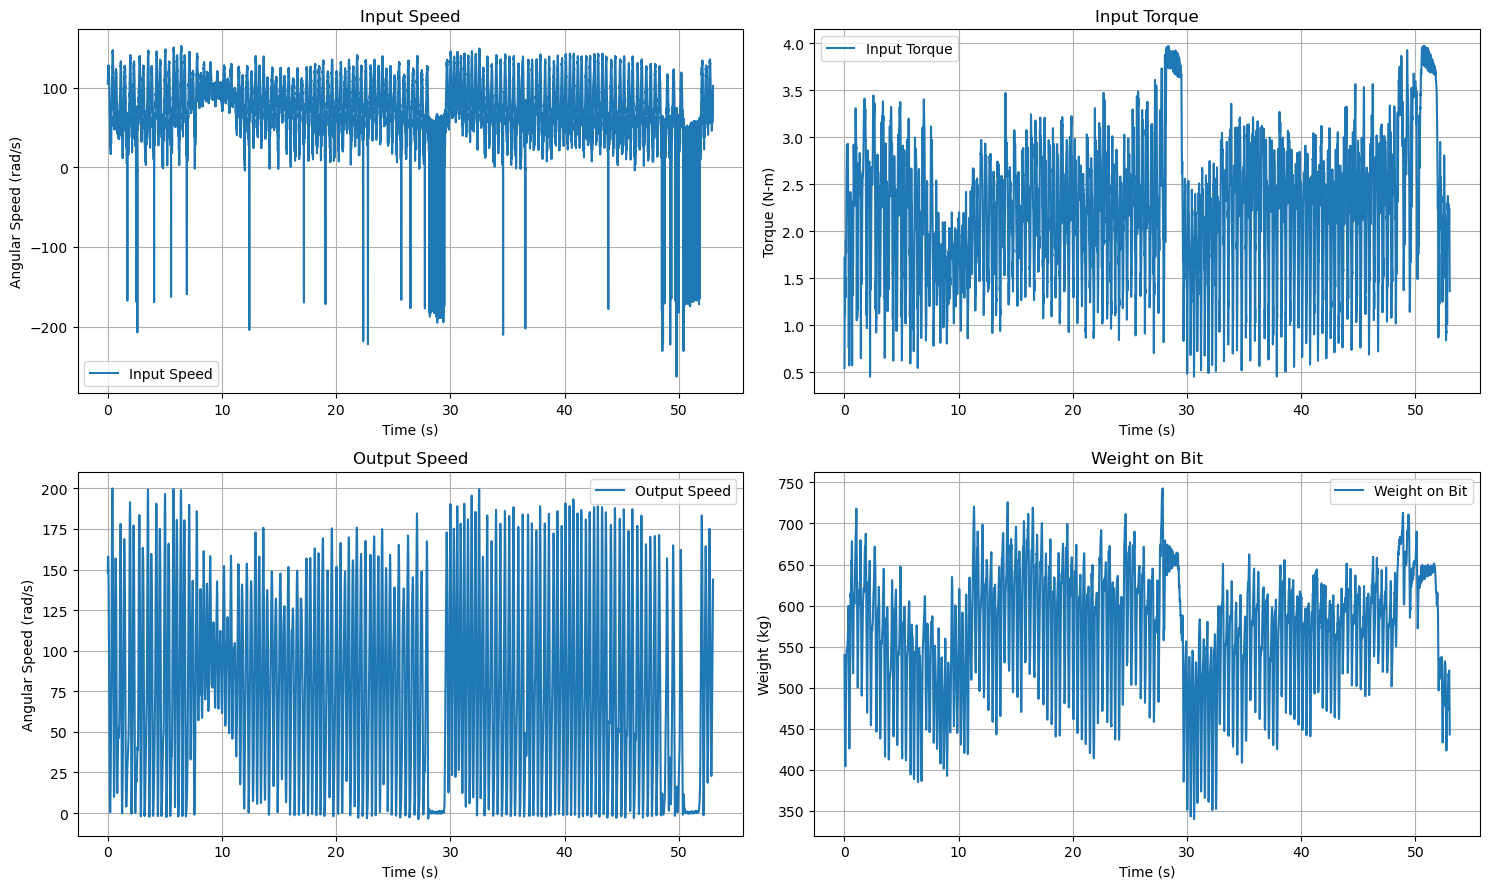

In [ ]:
# Converting columns to numpy arrays for plotting
time = df[["Time"]].values.astype('float32')
output_speed = df[["Output Speed"]].values.astype('float32')
input_torque = df[["Input Torque"]].values.astype('float32')
input_speed = df[["Input Speed"]].values.astype('float32')
weight_on_bit = df[["Weight on bit"]].values.astype('float32')

# Plotting the dataset
fig, axs = plt.subplots(2, 2, figsize=(15, 9))

# Plot Input Speed
axs[0, 0].plot(time, input_speed, label='Input Speed')
axs[0, 0].set_title('Input Speed')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Angular Speed (rad/s)')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot Input Torque
axs[0, 1].plot(time, input_torque, label='Input Torque')
axs[0, 1].set_title('Input Torque')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Torque (N-m)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot Output Speed
axs[1, 0].plot(time, output_speed, label='Output Speed')
axs[1, 0].set_title('Output Speed')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Angular Speed (rad/s)')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot Weight on Bit
axs[1, 1].plot(time, weight_on_bit, label='Weight on Bit')
axs[1, 1].set_title('Weight on Bit')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Weight (kg)')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# **Pytorch LSTM Implementation**


# Pre-Processing the Training Data

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

xy = np.loadtxt('experimental/Training.csv', delimiter=",", dtype=np.object_, skiprows=1)

# Convert the data to a 2D NumPy array of floats
features = np.array(xy[:, 1:], dtype=np.float32)

from sklearn.preprocessing import MinMaxScaler
feature_scaler = MinMaxScaler(feature_range=(0,1))
scaled_features = feature_scaler.fit_transform(features)

# Convert the NumPy array to a PyTorch tensor
Training_set = torch.from_numpy(scaled_features).to(device)

print("=================Creating_Dataset==================\n", Training_set.shape, "\n")

set_to_scale_features = []
set_to_scale_labels = []

# # Loop through the array to create the feature and label sets
for i in range(30, Training_set.shape[0]):
    set_to_scale_features.append(Training_set[i-30:i, [1, 2]].cpu().numpy())
    set_to_scale_labels.append(Training_set[i, [0, 3]].cpu().numpy())

# # Convert lists to NumPy arrays
set_to_scale_features = np.array(set_to_scale_features)
set_to_scale_labels = np.array(set_to_scale_labels)


print("=================Creating Features and Labels==================\n", set_to_scale_features.shape, "\n", set_to_scale_labels.shape, "\n" )

# # Reshape the feature set
X_train = torch.from_numpy(set_to_scale_features.reshape(set_to_scale_features.shape[0], set_to_scale_features.shape[1], 2)).to(device)

# # Convert labels to PyTorch tensor
Y_train = torch.from_numpy(set_to_scale_labels.reshape(set_to_scale_labels.shape[0], 2)).to(device)

print("=================Converting Features and Labels to Tensors==================\n", X_train.shape, "\n", Y_train.shape, "\n" )

# set_to_scale_labels = set_to_scale_labels.unsqueeze(1)
# print("Unsqueezed the labels to combine", set_to_scale_labels.shape)

=================Creating_Dataset==================
 torch.Size([53000, 4]) 

=================Creating Features and Labels==================
 (52970, 30, 2) 
 (52970, 2) 

=================Converting Features and Labels to Tensors==================
 torch.Size([52970, 30, 2]) 
 torch.Size([52970, 2]) 



In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

xy = np.loadtxt('experimental/Testing.csv', delimiter=",", dtype=np.object_, skiprows=1)

# Convert the data to a 2D NumPy array of floats
test_features = np.array(xy[:, 1:], dtype=np.float32)

scaled_test_features = feature_scaler.transform(test_features)

# Convert the NumPy array to a PyTorch tensor
Testing_set = torch.from_numpy(scaled_test_features).to(device)

print("=================Creating_Dataset==================\n", Testing_set.shape, "\n")

set_to_scale_test_features = []
set_to_scale_test_labels = []

# # Loop through the array to create the feature and label sets
for i in range(30, Testing_set.shape[0]):
    set_to_scale_test_features.append(Testing_set[i-30:i, [1, 2]].cpu().numpy())
    set_to_scale_test_labels.append(Testing_set[i, [0, 3]].cpu().numpy())

# # Convert lists to NumPy arrays
set_to_scale_test_features = np.array(set_to_scale_test_features)
set_to_scale_test_labels = np.array(set_to_scale_test_labels)


print("=================Creating Features and Labels==================\n", set_to_scale_test_features.shape, "\n", set_to_scale_test_labels.shape, "\n" )

# # Reshape the feature set
X_test = torch.from_numpy(set_to_scale_test_features.reshape(set_to_scale_test_features.shape[0], set_to_scale_test_features.shape[1], 2)).to(device)

# # Convert labels to PyTorch tensor
Y_test = torch.from_numpy(set_to_scale_test_labels.reshape(set_to_scale_test_labels.shape[0], 2)).to(device)

print("=================Converting Features and Labels to Tensors==================\n", X_test.shape, "\n", Y_test.shape, "\n" )


=================Creating_Dataset==================
 torch.Size([6000, 4]) 

=================Creating Features and Labels==================
 (5970, 30, 2) 
 (5970, 2) 

=================Converting Features and Labels to Tensors==================
 torch.Size([5970, 30, 2]) 
 torch.Size([5970, 2]) 



In [6]:
# # Creating dataset objects to process nn data through pytorch
from torch.utils.data import Dataset

class TSA(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __getitem__(self, index) :
    return self.X[index], self.Y[index]

  def __len__(self):
    return len(self.X)

train_dataset = TSA(X_train, Y_train)
test_dataset = TSA(X_test, Y_test)

# train_dataset

# # Using data_loader to classify data in required format
from torch.utils.data import DataLoader

batch_size = 30

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Print the batch sizes to confirm
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([30, 30, 2]) torch.Size([30, 2])


# LSTM Training

In [7]:
import numpy as np
import torch
import torch.nn as nn

# Define the hyperparameters
input_size = 2
hidden_size = 120
num_stacked_layers = 5
fc_size1 = 140
fc_size2 = 280
fc_size3 = 360
output_size = 2
dropout = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating a Pytorch LSTM nn model to train the model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm1 = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True, dropout=dropout)

        self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.Linear(hidden_size, fc_size1)

        self.fc2 = nn.Linear(fc_size1, fc_size2)

        self.fc3 = nn.Linear(fc_size2, fc_size3)

        self.fc4 = nn.Linear(fc_size3, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_stacked_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_stacked_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm1(x, (h0, c0))
        out = self.dropout(out)

        out = self.fc1(out[:, -1, :])
        out = nn.ReLU()(out)

        out = self.fc2(out)
        out = nn.ReLU()(out)

        out = self.fc3(out)
        out = nn.ReLU()(out)

        out = self.fc4(out)

        return out

# Initialize the model
model = LSTMModel(input_size, hidden_size, num_stacked_layers, dropout, output_size=output_size)
model.to(device)

# Example to print model summary
print(model)


LSTMModel(
  (lstm1): LSTM(2, 120, num_layers=5, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=120, out_features=140, bias=True)
  (fc2): Linear(in_features=140, out_features=280, bias=True)
  (fc3): Linear(in_features=280, out_features=360, bias=True)
  (fc4): Linear(in_features=360, out_features=2, bias=True)
)


In [9]:
import torch.optim as optim
learning_rate = 0.001
num_epochs = 20

best_val_loss = float('inf')
patience = 5
counter = 0

val_loss_list = []

# Define your loss function
loss_function = nn.MSELoss()

# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Running epochs
for epoch in range(num_epochs):
    # Set model to training mode
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(batch_index)
        if batch_index % 2 == 1:
          avg_loss_across_batches = running_loss / 100
          print('Batch {0}, Loss: {1: .6f}, Epoch: {2}'.format(batch_index+1, avg_loss_across_batches, epoch+1))

# Validate every epoch
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
          output = model(x_batch)
          loss = loss_function(output, y_batch)
          running_loss += loss

    val_loss = running_loss / len(test_loader)
    print('Validation Loss {0: .3f}'.format(val_loss))

    print('###################################################')

    running_loss = 0.0

    val_loss_list.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            print(val_loss_list)
            print("Best_Validation_Loss", best_val_loss)
            break

# Save the model
model_save_path = 'model.pth'
torch.save(model.state_dict(), model_save_path)


Epoch: 1
Batch 2, Loss:  0.005717, Epoch: 1
Batch 4, Loss:  0.010154, Epoch: 1
Batch 6, Loss:  0.013191, Epoch: 1
Batch 8, Loss:  0.014962, Epoch: 1
Batch 10, Loss:  0.016709, Epoch: 1
Batch 12, Loss:  0.017981, Epoch: 1
Batch 14, Loss:  0.019037, Epoch: 1
Batch 16, Loss:  0.020151, Epoch: 1
Batch 18, Loss:  0.021729, Epoch: 1
Batch 20, Loss:  0.022830, Epoch: 1
Batch 22, Loss:  0.024113, Epoch: 1
Batch 24, Loss:  0.025367, Epoch: 1
Batch 26, Loss:  0.026506, Epoch: 1
Batch 28, Loss:  0.027684, Epoch: 1
Batch 30, Loss:  0.028970, Epoch: 1
Batch 32, Loss:  0.030227, Epoch: 1
Batch 34, Loss:  0.031521, Epoch: 1
Batch 36, Loss:  0.032680, Epoch: 1
Batch 38, Loss:  0.033907, Epoch: 1
Batch 40, Loss:  0.035135, Epoch: 1
Batch 42, Loss:  0.036587, Epoch: 1
Batch 44, Loss:  0.037913, Epoch: 1
Batch 46, Loss:  0.039265, Epoch: 1
Batch 48, Loss:  0.040502, Epoch: 1
Batch 50, Loss:  0.041600, Epoch: 1
Batch 52, Loss:  0.042816, Epoch: 1
Batch 54, Loss:  0.043911, Epoch: 1
Batch 56, Loss:  0.0451

# LSTM Plotting

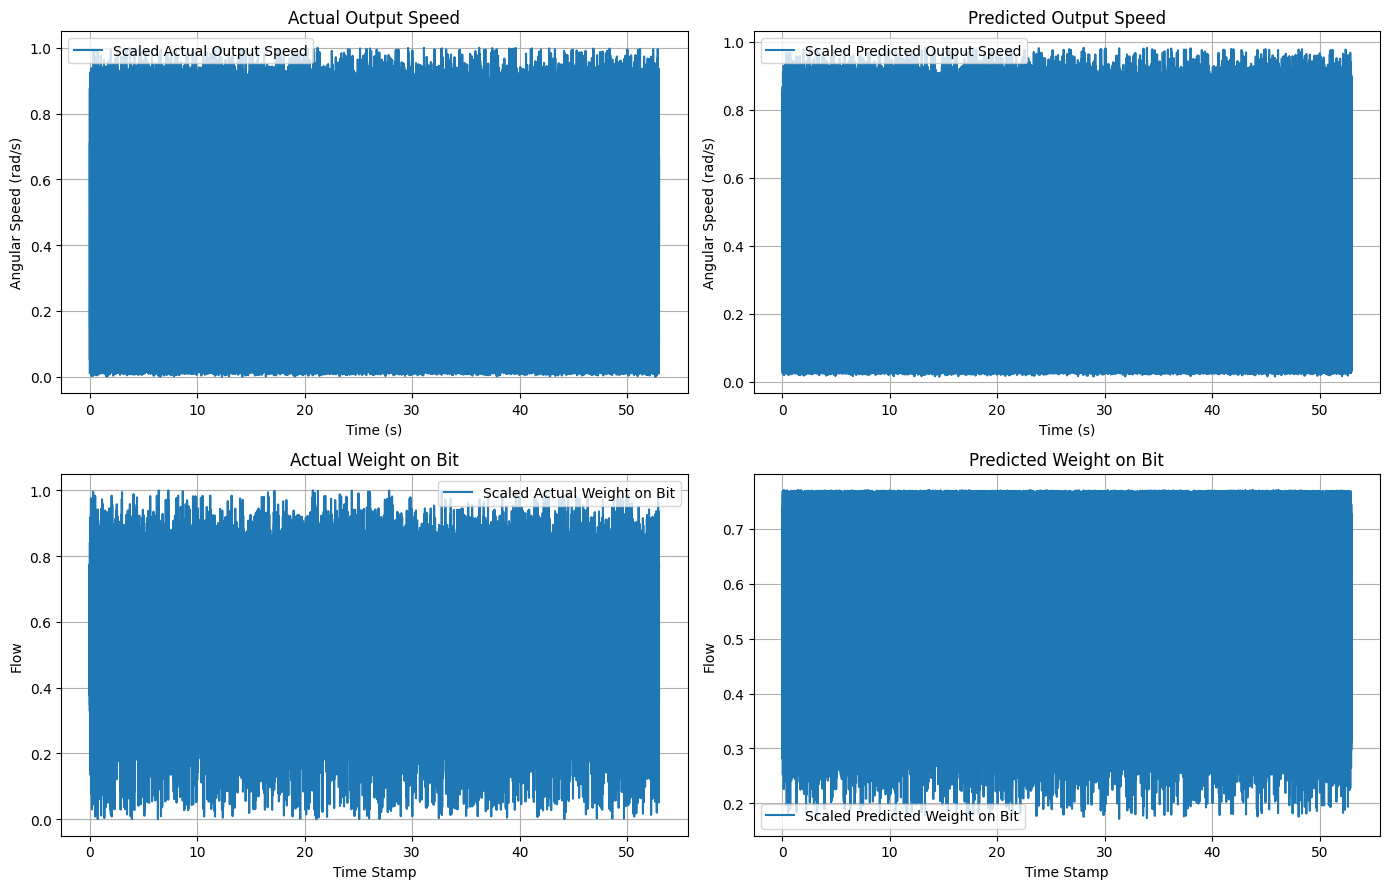

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize predictions and actual values storage
actual_data = []
predicted_data = []

for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
        predicted = model(x_batch).to('cpu').numpy()

    actual_data.append(y_batch.to('cpu').numpy())
    predicted_data.append(predicted)

# Convert lists to numpy arrays for plotting
actual_data = np.concatenate(actual_data, axis=0)
predicted_data = np.concatenate(predicted_data, axis=0)

df = pd.read_csv('experimental/Training.csv')
time = df['Time'].values.astype('float32')
time = time[:len(time)-30]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 9))

# First subplot - Actual Output Speed
axs[0, 0].plot(time, actual_data[:, 0], label='Scaled Actual Output Speed')
axs[0, 0].set_title('Actual Output Speed')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Angular Speed (rad/s)')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Second subplot - Predicted Output Speed
axs[0, 1].plot(time, predicted_data[:, 0], label='Scaled Predicted Output Speed')
axs[0, 1].set_title('Predicted Output Speed')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Angular Speed (rad/s)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Third subplot - Actual Weight on Bit
axs[1, 0].plot(time, actual_data[:, 1], label='Scaled Actual Weight on Bit')
axs[1, 0].set_title('Actual Weight on Bit')
axs[1, 0].set_xlabel('Time Stamp')
axs[1, 0].set_ylabel('Flow')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Fourth subplot - Predicted Weight on Bit
axs[1, 1].plot(time, predicted_data[:, 1], label='Scaled Predicted Weight on Bit')
axs[1, 1].set_title('Predicted Weight on Bit')
axs[1, 1].set_xlabel('Time Stamp')
axs[1, 1].set_ylabel('Flow')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


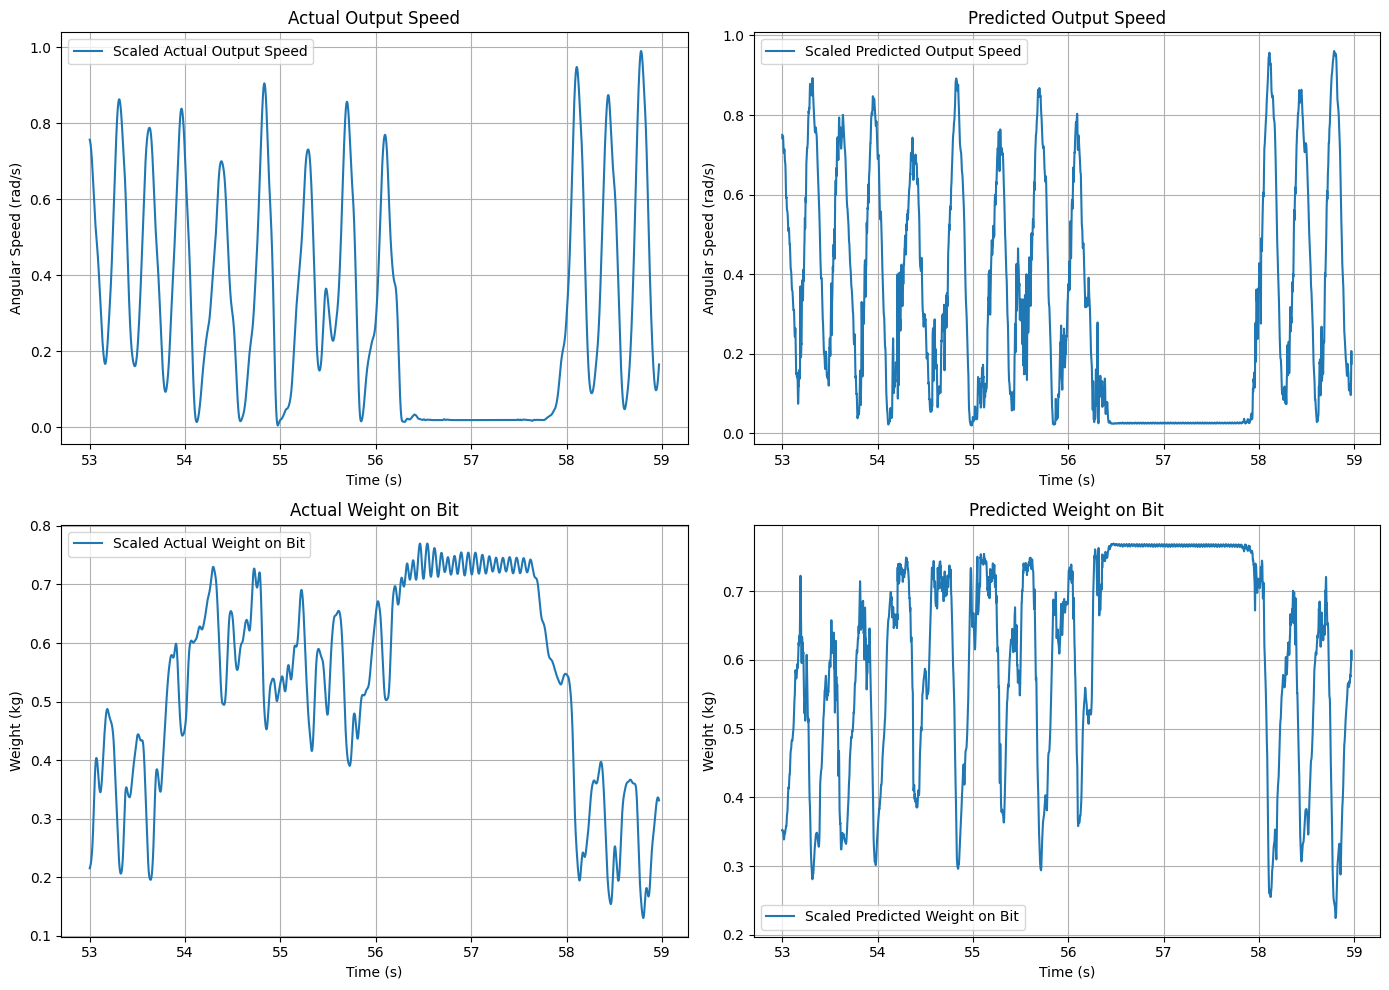

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize predictions and actual values storage
actual_data = []
predicted_data = []

for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
        predicted = model(x_batch).to('cpu').numpy()

    actual_data.append(y_batch.to('cpu').numpy())
    predicted_data.append(predicted)

# Convert lists to numpy arrays for plotting
actual_data = np.concatenate(actual_data, axis=0)
predicted_data = np.concatenate(predicted_data, axis=0)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

df = pd.read_csv('experimental/Testing.csv')
time = df['Time'].values.astype('float32')
time = time[:len(time)-30]

# First subplot - Actual Output Speed
axs[0, 0].plot(time, actual_data[:, 0], label='Scaled Actual Output Speed')
axs[0, 0].set_title('Actual Output Speed')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Angular Speed (rad/s)')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Second subplot - Predicted Output Speed
axs[0, 1].plot(time, predicted_data[:, 0], label='Scaled Predicted Output Speed')
axs[0, 1].set_title('Predicted Output Speed')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Angular Speed (rad/s)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Third subplot - Actual Weight on Bit
axs[1, 0].plot(time, actual_data[:, 1], label='Scaled Actual Weight on Bit')
axs[1, 0].set_title('Actual Weight on Bit')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Weight (kg)')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Fourth subplot - Predicted Weight on Bit
axs[1, 1].plot(time, predicted_data[:, 1], label='Scaled Predicted Weight on Bit')
axs[1, 1].set_title('Predicted Weight on Bit')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Weight (kg)')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


## Loading the model and furnishing the output data

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize predictions and actual values storage
actual_data = []
predicted_data = []

# Define the hyperparameters
input_size = 2
hidden_size = 120
num_stacked_layers = 5
fc_size1 = 140
fc_size2 = 280
fc_size3 = 360
output_size = 2
dropout = 0.1

# Initialize the model
model = LSTMModel(input_size, hidden_size, num_stacked_layers, dropout=0.0, output_size=output_size)

model_path = "model.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
model.load_state_dict(torch.load(model_path))

model.to(device)

model.eval()


cpu


LSTMModel(
  (lstm1): LSTM(2, 120, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc1): Linear(in_features=120, out_features=140, bias=True)
  (fc2): Linear(in_features=140, out_features=280, bias=True)
  (fc3): Linear(in_features=280, out_features=360, bias=True)
  (fc4): Linear(in_features=360, out_features=2, bias=True)
)

In [23]:
for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
        predicted = model(x_batch).to('cpu').numpy()

    actual_data.append(y_batch.to('cpu').numpy())
    predicted_data.append(predicted)

# Convert lists to numpy arrays for plotting
actual_data = np.concatenate(actual_data, axis=0)
predicted_data = np.concatenate(predicted_data, axis=0)

print("Actual_Data_shape", actual_data.shape, "Predicted_Data_shape", predicted_data.shape)

Actual_Data_shape (52970, 2) Predicted_Data_shape (52970, 2)


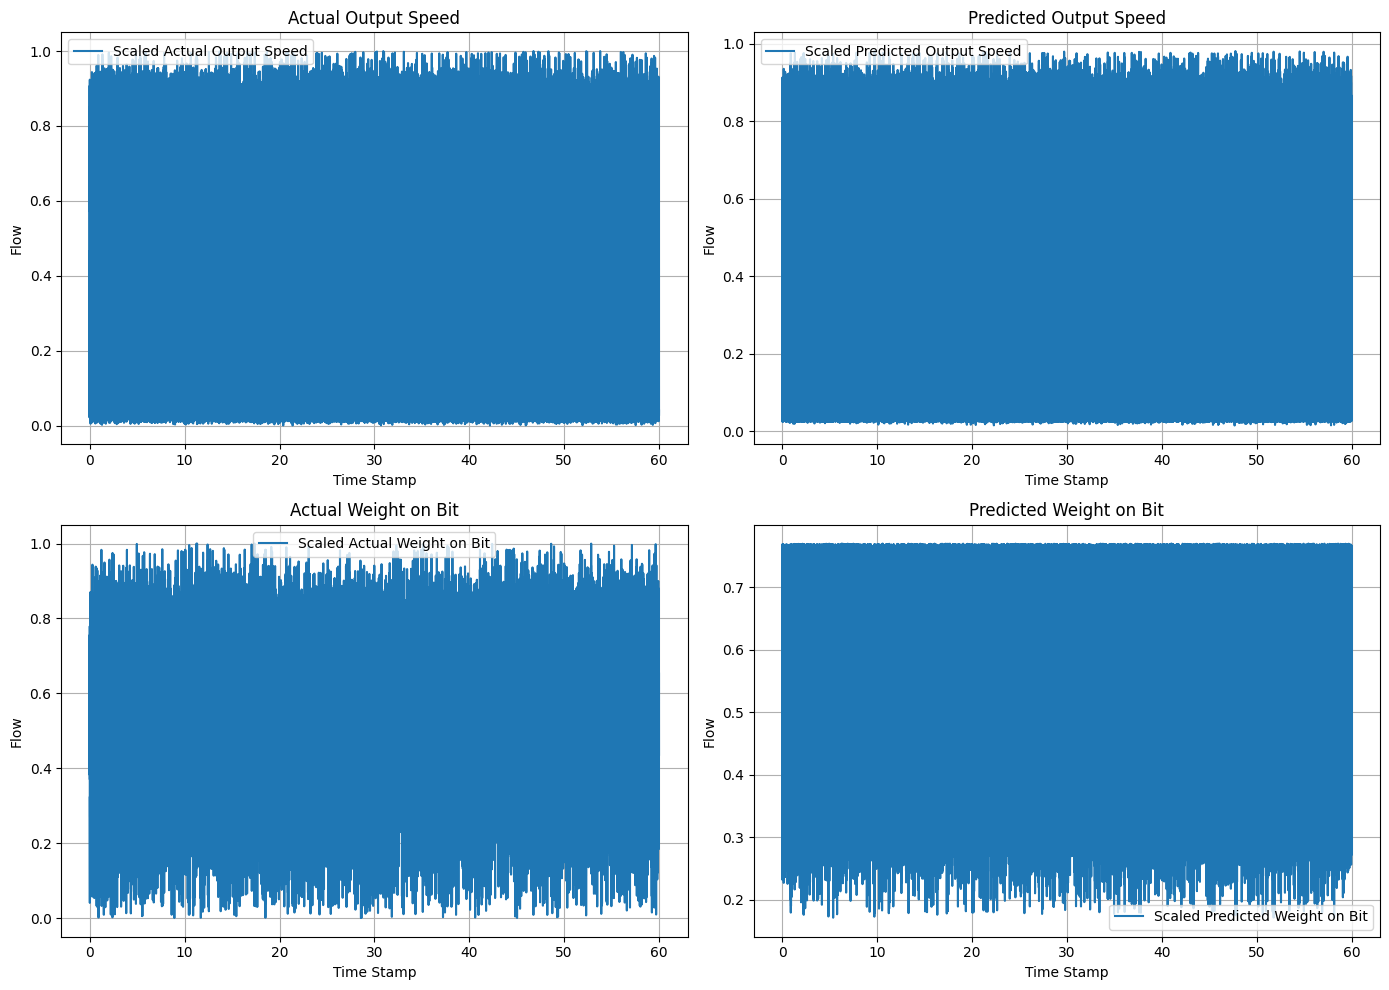

In [24]:

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

time = np.linspace(0, 60, len(actual_data))

# First subplot - Actual Output Speed
axs[0, 0].plot(time, actual_data[:, 0], label='Scaled Actual Output Speed')
axs[0, 0].set_title('Actual Output Speed')
axs[0, 0].set_xlabel('Time Stamp')
axs[0, 0].set_ylabel('Flow')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Second subplot - Predicted Output Speed
axs[0, 1].plot(time, predicted_data[:, 0], label='Scaled Predicted Output Speed')
axs[0, 1].set_title('Predicted Output Speed')
axs[0, 1].set_xlabel('Time Stamp')
axs[0, 1].set_ylabel('Flow')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Third subplot - Actual Weight on Bit
axs[1, 0].plot(time, actual_data[:, 1], label='Scaled Actual Weight on Bit')
axs[1, 0].set_title('Actual Weight on Bit')
axs[1, 0].set_xlabel('Time Stamp')
axs[1, 0].set_ylabel('Flow')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Fourth subplot - Predicted Weight on Bit
axs[1, 1].plot(time, predicted_data[:, 1], label='Scaled Predicted Weight on Bit')
axs[1, 1].set_title('Predicted Weight on Bit')
axs[1, 1].set_xlabel('Time Stamp')
axs[1, 1].set_ylabel('Flow')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


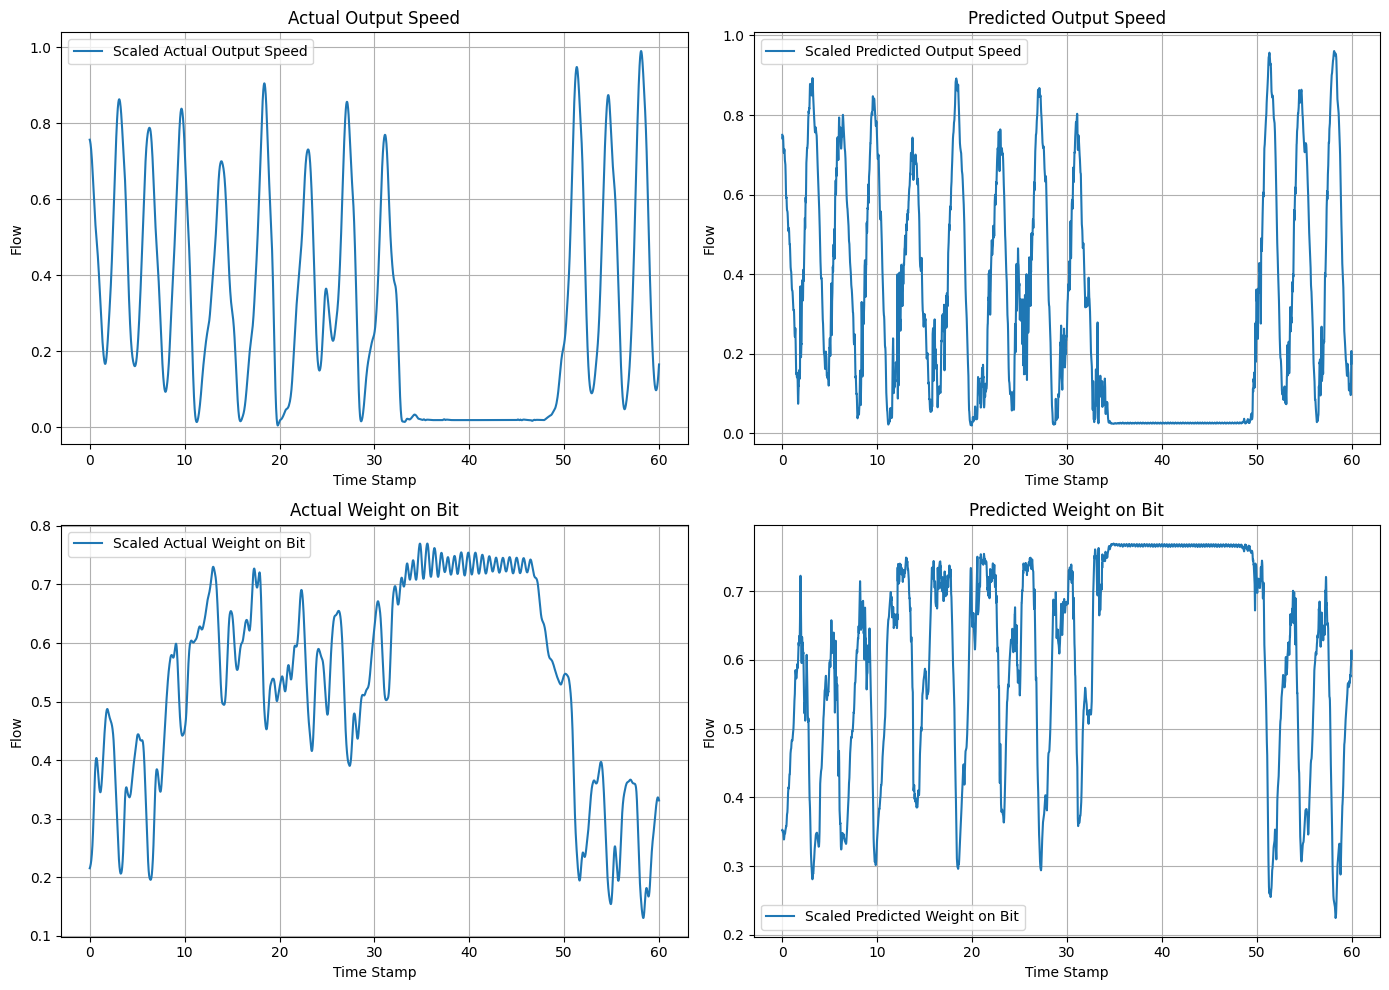

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize predictions and actual values storage
actual_data = []
predicted_data = []

for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
        predicted = model(x_batch).to('cpu').numpy()

    actual_data.append(y_batch.to('cpu').numpy())
    predicted_data.append(predicted)

# Convert lists to numpy arrays for plotting
actual_data = np.concatenate(actual_data, axis=0)
predicted_data = np.concatenate(predicted_data, axis=0)

time = np.linspace(0, 60, len(actual_data))
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# First subplot - Actual Output Speed
axs[0, 0].plot(time, actual_data[:, 0], label='Scaled Actual Output Speed')
axs[0, 0].set_title('Actual Output Speed')
axs[0, 0].set_xlabel('Time Stamp')
axs[0, 0].set_ylabel('Flow')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Second subplot - Predicted Output Speed
axs[0, 1].plot(time, predicted_data[:, 0], label='Scaled Predicted Output Speed')
axs[0, 1].set_title('Predicted Output Speed')
axs[0, 1].set_xlabel('Time Stamp')
axs[0, 1].set_ylabel('Flow')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Third subplot - Actual Weight on Bit
axs[1, 0].plot(time, actual_data[:, 1], label='Scaled Actual Weight on Bit')
axs[1, 0].set_title('Actual Weight on Bit')
axs[1, 0].set_xlabel('Time Stamp')
axs[1, 0].set_ylabel('Flow')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Fourth subplot - Predicted Weight on Bit
axs[1, 1].plot(time, predicted_data[:, 1], label='Scaled Predicted Weight on Bit')
axs[1, 1].set_title('Predicted Weight on Bit')
axs[1, 1].set_xlabel('Time Stamp')
axs[1, 1].set_ylabel('Flow')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [26]:
# Concatenating the test train and analysing the
print(type(X_train))
X_train = X_train.cpu().numpy()
print(X_train.shape)

X_test = X_test.cpu().numpy()
print(X_test.shape)

# dataset_total = np.concatenate((X_train, X_test))
# print(dataset_total.shape)
inputs = X_train[len(X_train) - 30:]
print(inputs.shape)
# inputs = inputs.reshape(-1, 2)
# print(inputs.shape)

<class 'torch.Tensor'>
(52970, 30, 2)
(5970, 30, 2)
(30, 30, 2)


In [27]:
input_tensor = torch.from_numpy(inputs).to(device)
print(input_tensor.shape)
model.eval()

with torch.no_grad():
  predicted_number = model(input_tensor)

predicted_number = predicted_number.cpu().numpy()

print("Predicted_Number_shape", predicted_number.shape)

torch.Size([30, 30, 2])
Predicted_Number_shape (30, 2)


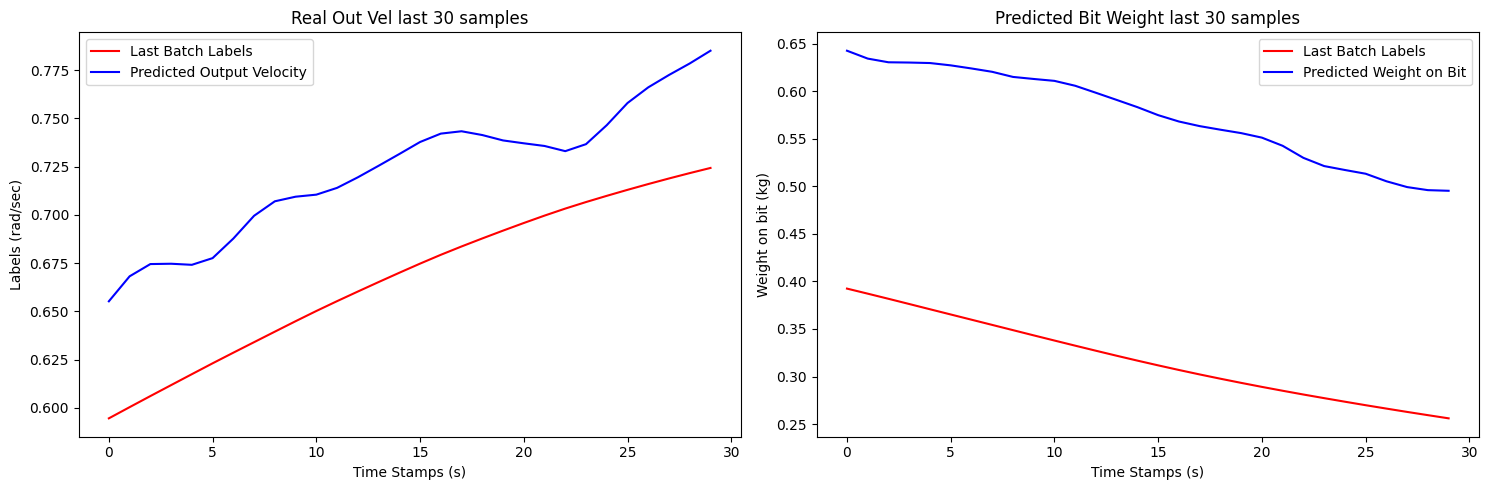

In [28]:
labels = set_to_scale_labels[len(set_to_scale_labels)-30:]

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(labels[:, 0], color = 'red', label = 'Last Batch Labels')
ax[0].plot(predicted_number[:, 0], color = 'blue', label = 'Predicted Output Velocity')
ax[0].set_xlabel('Time Stamps (s)')
ax[0].set_ylabel('Labels (rad/sec)')
ax[0].set_title("Real Out Vel last 30 samples")
ax[0].legend()

ax[1].plot(labels[:, 1], color = 'red', label = 'Last Batch Labels')
ax[1].plot(predicted_number[:, 1], color = 'blue', label = 'Predicted Weight on Bit')
ax[1].set_xlabel('Time Stamps (s)')
ax[1].set_ylabel('Weight on bit (kg)')
ax[1].set_title("Predicted Bit Weight last 30 samples")
ax[1].legend()

plt.tight_layout()
plt.show()